# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


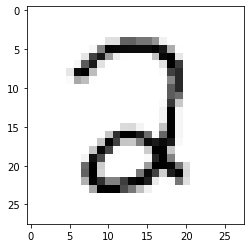

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2436
Training Accuracy: 0.6830, Testing Accuracy: 0.6976



Epoch 10, Loss 0.0769
Training Accuracy: 0.9280, Testing Accuracy: 0.9385



Epoch 20, Loss 0.0485
Training Accuracy: 0.9506, Testing Accuracy: 0.9607



Epoch 30, Loss 0.0384
Training Accuracy: 0.9604, Testing Accuracy: 0.9642



Epoch 40, Loss 0.0333
Training Accuracy: 0.9637, Testing Accuracy: 0.9682



Epoch 50, Loss 0.0303
Training Accuracy: 0.9671, Testing Accuracy: 0.9693



Epoch 60, Loss 0.0281
Training Accuracy: 0.9695, Testing Accuracy: 0.9698



Epoch 70, Loss 0.0265
Training Accuracy: 0.9708, Testing Accuracy: 0.9708



Epoch 80, Loss 0.0251
Training Accuracy: 0.9722, Testing Accuracy: 0.9713



Epoch 90, Loss 0.024
Training Accuracy: 0.9731, Testing Accuracy: 0.9708



Epoch 100, Loss 0.0231
Training Accuracy: 0.9740, Testing Accuracy: 0.9708



Epoch 110, Loss 0.0222
Training Accuracy: 0.9750, Testing Accuracy: 0.9713



Epoch 120, Loss 0.0215
Training Accuracy: 0.9756, Testing Accuracy: 0.9723



Epoch 130, Loss 0.0208
Training Accuracy: 0.9763, Testing Accuracy: 0.9728



Epoch 140, Loss 0.0201
Training Accuracy: 0.9773, Testing Accuracy: 0.9743



Epoch 150, Loss 0.0195
Training Accuracy: 0.9785, Testing Accuracy: 0.9738



Epoch 160, Loss 0.019
Training Accuracy: 0.9791, Testing Accuracy: 0.9743



Epoch 170, Loss 0.0185
Training Accuracy: 0.9801, Testing Accuracy: 0.9743



Epoch 180, Loss 0.018
Training Accuracy: 0.9810, Testing Accuracy: 0.9743



Epoch 190, Loss 0.0175
Training Accuracy: 0.9812, Testing Accuracy: 0.9748



Epoch 200, Loss 0.0171
Training Accuracy: 0.9816, Testing Accuracy: 0.9748



Epoch 210, Loss 0.0167
Training Accuracy: 0.9823, Testing Accuracy: 0.9753



Epoch 220, Loss 0.0163
Training Accuracy: 0.9827, Testing Accuracy: 0.9763



Epoch 230, Loss 0.0159
Training Accuracy: 0.9831, Testing Accuracy: 0.9773



Epoch 240, Loss 0.0155
Training Accuracy: 0.9837, Testing Accuracy: 0.9773



0.05606668437619475

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2295
Training Accuracy: 0.7516, Testing Accuracy: 0.7465



Epoch 10, Loss 0.1007
Training Accuracy: 0.9108, Testing Accuracy: 0.9224



Epoch 20, Loss 0.0788
Training Accuracy: 0.9258, Testing Accuracy: 0.9385



Epoch 30, Loss 0.0683
Training Accuracy: 0.9329, Testing Accuracy: 0.9471



Epoch 40, Loss 0.0619
Training Accuracy: 0.9382, Testing Accuracy: 0.9506



Epoch 50, Loss 0.0575
Training Accuracy: 0.9425, Testing Accuracy: 0.9536



Epoch 60, Loss 0.0543
Training Accuracy: 0.9458, Testing Accuracy: 0.9556



Epoch 70, Loss 0.0517
Training Accuracy: 0.9478, Testing Accuracy: 0.9587



Epoch 80, Loss 0.0497
Training Accuracy: 0.9498, Testing Accuracy: 0.9597



Epoch 90, Loss 0.048
Training Accuracy: 0.9513, Testing Accuracy: 0.9607



Epoch 100, Loss 0.0465
Training Accuracy: 0.9518, Testing Accuracy: 0.9617



Epoch 110, Loss 0.0453
Training Accuracy: 0.9532, Testing Accuracy: 0.9627



Epoch 120, Loss 0.0442
Training Accuracy: 0.9539, Testing Accuracy: 0.9627



Epoch 130, Loss 0.0433
Training Accuracy: 0.9543, Testing Accuracy: 0.9637



Epoch 140, Loss 0.0424
Training Accuracy: 0.9548, Testing Accuracy: 0.9642



Epoch 150, Loss 0.0417
Training Accuracy: 0.9556, Testing Accuracy: 0.9642



Epoch 160, Loss 0.041
Training Accuracy: 0.9564, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0404
Training Accuracy: 0.9566, Testing Accuracy: 0.9652



Epoch 180, Loss 0.0398
Training Accuracy: 0.9572, Testing Accuracy: 0.9647



Epoch 190, Loss 0.0393
Training Accuracy: 0.9578, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0388
Training Accuracy: 0.9582, Testing Accuracy: 0.9652



Epoch 210, Loss 0.0384
Training Accuracy: 0.9589, Testing Accuracy: 0.9647



Epoch 220, Loss 0.0379
Training Accuracy: 0.9591, Testing Accuracy: 0.9652



Epoch 230, Loss 0.0375
Training Accuracy: 0.9595, Testing Accuracy: 0.9652



Epoch 240, Loss 0.0372
Training Accuracy: 0.9600, Testing Accuracy: 0.9652



0.018992588014285227

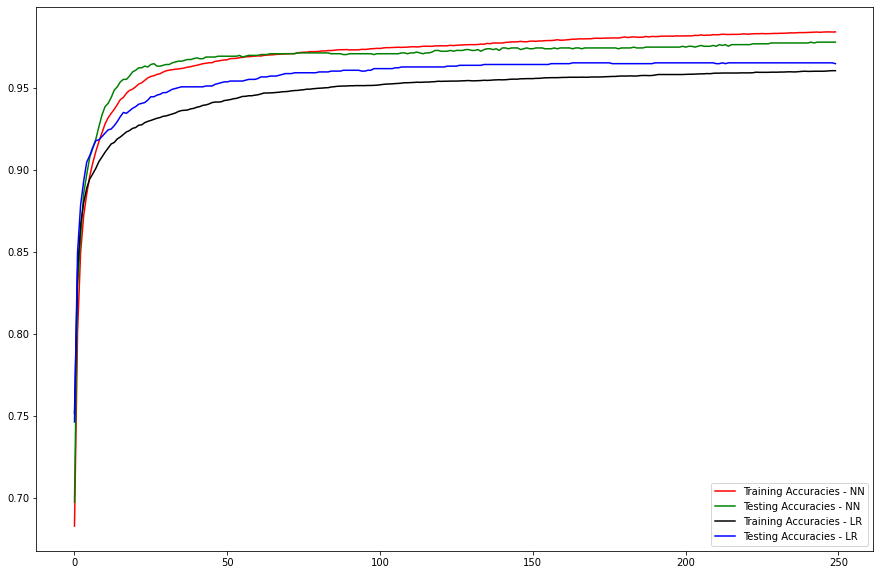

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

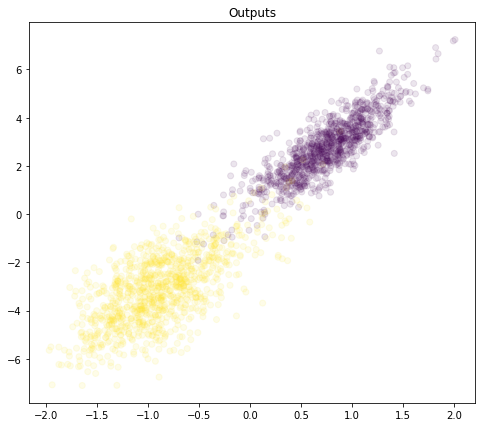

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

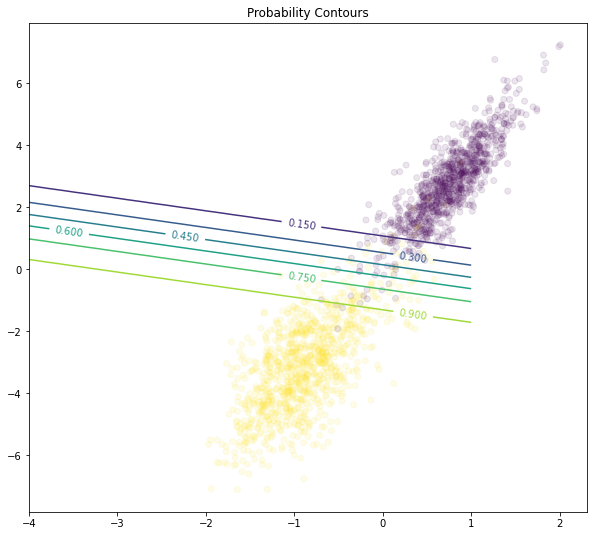

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );